<a href="https://colab.research.google.com/github/Chaelsy-kim/Capstone_Design/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import library
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# data load & split
metal_train='/content/gdrive/MyDrive/dataset/train/metal'
wood_train='/content/gdrive/MyDrive/dataset/train/wood'
metal_test='/content/gdrive/MyDrive/dataset/test/metal'
wood_test='/content/gdrive/MyDrive/dataset/test/wood'
metal_valid='/content/gdrive/MyDrive/dataset/valid/metal'
wood_valid='/content/gdrive/MyDrive/dataset/valid/wood'

metal_train_filepath = sorted([os.path.join(metal_train, f) for f in os.listdir(metal_train)])
wood_train_filepath = sorted([os.path.join(wood_train, f) for f in os.listdir(wood_train)])
metal_test_filepath = sorted([os.path.join(metal_test, f) for f in os.listdir(metal_test)])
wood_test_filepath = sorted([os.path.join(wood_test, f) for f in os.listdir(wood_test)])
metal_valid_filepath = sorted([os.path.join(metal_valid, f) for f in os.listdir(metal_valid)])
wood_valid_filepath = sorted([os.path.join(wood_valid, f) for f in os.listdir(wood_valid)])

train_filepaths = [*metal_train_filepath, *wood_train_filepath]
test_filepaths = [*metal_test_filepath, *wood_test_filepath]
val_filepaths = [*metal_valid_filepath, *wood_valid_filepath]


print(len(train_filepaths), len(val_filepaths), len(test_filepaths))

1050 90 20


In [4]:
# data preprocessing
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [5]:
# define custom dataset
class MetalvsWoodDataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-2]
        if label == 'metal' :
            label = 1
        elif label == 'wood' :
            label = 0
            
        return img_transformed, label

In [6]:
# define variables

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [7]:
train_dataset = MetalvsWoodDataset(train_filepaths, transform=ImageTransform(size, mean, std),
                               phase='train')
val_dataset = MetalvsWoodDataset(val_filepaths, transform=ImageTransform(size, mean, std),
                             phase='val')
test_dataset =MetalvsWoodDataset(test_filepaths, transform=ImageTransform(size, mean, std),
                            phase='test')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


In [8]:
# load dataset to memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0])


In [9]:
# create model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# optimizer, loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
# define training function
def train_model(model, dataloader_dict, criterion, optimizer, n_epochs) :
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(n_epochs) :
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()
                
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                        
                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:0f}')

    return model
n_epochs = 20
model = train_model(model, dataloader_dict, criterion, optimizer, n_epochs)

Epoch 1/20
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 2.2057 Acc : 0.5038


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 2.6595 Acc : 0.5556
Epoch 2/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.8793 Acc : 0.5238


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.7245 Acc : 0.5889
Epoch 3/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.7761 Acc : 0.6143


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.5565 Acc : 0.6222
Epoch 4/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.4500 Acc : 0.7762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 1.3183 Acc : 0.5667
Epoch 5/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.5213 Acc : 0.7381


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.3825 Acc : 0.8333
Epoch 6/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.3260 Acc : 0.8457


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.3936 Acc : 0.8000
Epoch 7/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.2468 Acc : 0.8981


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.3770 Acc : 0.8333
Epoch 8/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.2464 Acc : 0.8990


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.2933 Acc : 0.8444
Epoch 9/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.2334 Acc : 0.9000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.2110 Acc : 0.9333
Epoch 10/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.2418 Acc : 0.8981


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.3133 Acc : 0.8333
Epoch 11/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.1611 Acc : 0.9343


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.3516 Acc : 0.8222
Epoch 12/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.1751 Acc : 0.9238


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1502 Acc : 0.9333
Epoch 13/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.1825 Acc : 0.9190


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1679 Acc : 0.9556
Epoch 14/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.1862 Acc : 0.9152


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1720 Acc : 0.9444
Epoch 15/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.1297 Acc : 0.9410


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1449 Acc : 0.9667
Epoch 16/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.0941 Acc : 0.9610


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1727 Acc : 0.9333
Epoch 17/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.0700 Acc : 0.9676


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1657 Acc : 0.9556
Epoch 18/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.0636 Acc : 0.9743


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1949 Acc : 0.9444
Epoch 19/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.0569 Acc : 0.9771


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.1515 Acc : 0.9556
Epoch 20/20
--------------------


  0%|          | 0/33 [00:00<?, ?it/s]

train Loss : 0.0531 Acc : 0.9771


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.2406 Acc : 0.9222
Training complete in 5m 25.734767


In [12]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad() :
    for test_path in tqdm(test_filepaths) :
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({'id' : id_list,
                   'label' : pred_list})
res.to_csv('./alexnet.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# result visualization
def display_img_grid(img_filepath, cols=5) :
    rows = len(img_filepath) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_filepath in enumerate(img_filepath) :
        image = cv2.imread(img_filepath)
        true_label = os.path.normpath(img_filepath).split(os.sep)[-2] 
        pred_label = res.loc[i,'label']
        if pred_label > 0.5 :
            pred_label = 'metal'
        else :
            pred_label = 'wood'
        color = 'green' if true_label == pred_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

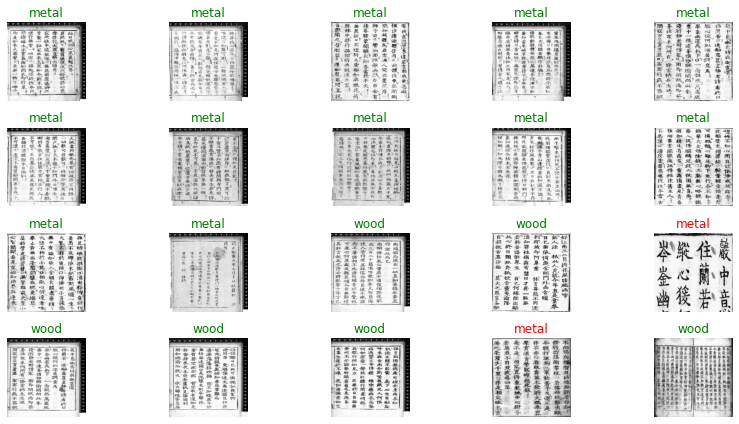

In [14]:
display_img_grid(test_filepaths)